# Device backend noise model simulations


## Introduction

This notebook shows how to use the Qiskit Aer `noise` module to automatically generate a basic noise model for an IBMQ hardware device, and use this model to do noisy simulations of `QuantumCircuits` to study the effects of errors which occur on real devices.

Note, that these automatic models are only an *approximation* of the real errors that occur on actual devices, due to the fact that they must be build from a limited set of input parameters related to *average error rates* on gates. The study of quantum errors on real devices is an active area of research and we discuss the Qiskit Aer tools for configuring more detailed noise models in another notebook.

In [9]:
%matplotlib inline
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

## Device Backend Noise Model

The *Qiskit Aer* device noise model automatically generates a simplified noise model for a real device. This model is generated using the calibration information reported in the `BackendProperties` of a device and takes into account

* The *gate_error* probability of each basis gate on each qubit.
* The *gate_length* of each basis gate on each qubit.
* The $T_1$, $T_2$ relaxation time constants of each qubit.
* The readout error probability of each qubit.

### Terra Mock  Backends

We will use real noise data for an IBM Quantum device using the date stored in Qiskit Terra. Specifically, in this tutorial, the device is `ibmq_vigo`.

In [10]:
# from qiskit.test.mock import FakeVigo
# device_backend = FakeVigo()

from qiskit.test.mock import FakeSydney
device_backend = FakeSydney()

### Test circuit for device and simulation comparison

Now we construct a test circuit to compare the output of the real device with the noisy output simulated on the Qiskit Aer `AerSimulator`. We will prepare a 3-qubit GHZ state $\frac{1}{2}(|0,0,0\rangle + |1,1,1\rangle)$ on qubits 0, 1 and 2. Before running with noise or on the device we show the ideal expected output with no noise.

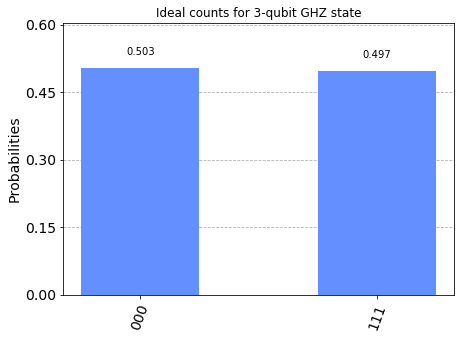

In [11]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

sim_ideal = AerSimulator()

# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')

## Generating a simulator that mimics a device

We call `from_backend` to create a simulator for `ibmq_vigo`:

In [13]:
sim_syd = AerSimulator.from_backend(device_backend)

By storing the device properties in `vigo_simulator`, we ensure that the appropriate basis gates and coupling map are used when compiling circuits for simulation, thereby most closely mimicking the gates that will be executed on a real device. In addition `vigo_simulator` contains an approximate noise model consisting of:

* **Single-qubit gate errors** consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.
* **Two-qubit gate errors** consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
* **Single-qubit readout errors** on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the `thermal_relaxation_error` function from `aer.noise.errors` module, along with the individual qubit $T_1$ and $T_2$ parameters, and the `gate_time` parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the `gate_error` value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit `readout_errors`.

### Running a noise simulation

Once we have created a noisy simulator backend based on a real device we can use it to run noisy simulations.

**Important:** When running noisy simulations it is *critical* to `transpile` the circuit for the backend so that the circuit is transpiled to the correct noisy basis gate set for the backend.

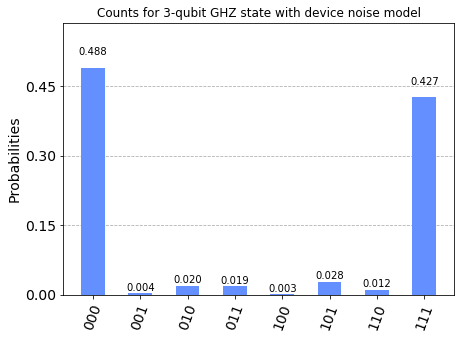

In [17]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_syd.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 3-qubit GHZ state with device noise model")

If transpilation is skipped noise from the device noise model will not be applied to gates in the circuit that are supported by the simulator, but not supported by the mimicked backend.

In [6]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright